In [1]:
#第3回課題#

In [2]:
!pip install pandas requests html5lib lxml

In [3]:
import pandas as pd
import time
import requests
from io import StringIO

#紅白歌合戦のデータ
# --- 設定 ---
# 取得する年を設定 (2015年から2025年まで)
YEARS = range(2015, 2026) 
PROGRAM_NAME = 'NHK紅白歌合戦'

# --- 関数定義 ---
def get_kouhaku_performers(year):
    """指定された年の紅白歌合戦の出演者リスト（回数・曲名含む）を取得する関数"""
    
    # 紅白の「回数」を計算 (第75回が2024年)
    kai = year - 2024 + 75
    
    url = f"https://ja.wikipedia.org/wiki/第{kai}回NHK紅白歌合戦"
    print(f"{year}年 (第{kai}回) のデータを取得中... URL: {url}")
    
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        tables = pd.read_html(StringIO(response.text))
        
        found_dfs = [] 
        for table in tables:
            if len(table) < 15 or not (4 <= len(table.columns) <= 8):
                continue
            
            columns_str = ''.join(map(str, table.columns.tolist()))
            if '歌手' in columns_str:
                temp_df = table.copy()
                
                if isinstance(temp_df.columns, pd.MultiIndex):
                    temp_df.columns = ['_'.join(map(str, col)).strip() for col in temp_df.columns]
                
                found_dfs.append(temp_df)
        
        if not found_dfs:
            print(f"  [警告] {year}年の出演者テーブルが見つかりませんでした。")
            return None

        performers_df = pd.concat(found_dfs, ignore_index=True)

        # === 修正箇所: カラム名の判定を柔軟に ===
        artist_col_name = None
        appearances_col_name = None
        song_col_name = None
        for col in performers_df.columns:
            col_str = str(col)
            if '歌手' in col_str:
                artist_col_name = col
            # 「回」または「回数」というカラムを探すように修正
            if col_str == '回' or '回数' in col_str:
                appearances_col_name = col
            if '曲目' in col_str:
                song_col_name = col
        
        if not (artist_col_name and appearances_col_name and song_col_name):
             print(f"  [警告] {year}年の必須カラム（歌手, 回, 曲目）が見つかりませんでした。")
             return None
        
        # 各カラムからデータを抽出・整形
        extracted_artists = performers_df[artist_col_name].astype(str).str.extract(r'([^(]+)')
        performers_df['artist'] = extracted_artists[0].str.strip() if not extracted_artists.empty else ''
        
        performers_df['appearances'] = performers_df[appearances_col_name].astype(str).str.replace('初', '1').str.extract(r'(\d+)').fillna(0).astype(int)

        performers_df['song'] = performers_df[song_col_name].astype(str)

        performers_df['year'] = year
        performers_df['program'] = PROGRAM_NAME
        
        print(f"  -> 成功: {len(performers_df)} 件のデータを取得")
        
        return performers_df[['year', 'program', 'artist', 'appearances', 'song']]

    except requests.exceptions.HTTPError:
        print(f"  [情報] {year}年のページはまだ存在しないか、アクセスできません。スキップします。")
        return None
    except Exception as e:
        print(f"  [エラー] {year}年で予期せぬエラーが発生しました: {e}")
        return None

# --- メイン処理 ---
if __name__ == '__main__':
    all_data_list = []

    for year in YEARS:
        df = get_kouhaku_performers(year)
        
        if df is not None:
            all_data_list.append(df)
        
        time.sleep(1)

    if all_data_list:
        final_df = pd.concat(all_data_list, ignore_index=True)
        
        output_filename = 'kouhaku_performers_full_2015-2025.csv'
        final_df.to_csv(output_filename, index=False)
        
        print("\n処理が完了しました。")
        print(f"ファイル '{output_filename}' が作成されました。")
        print("--- データサンプル ---")
        print(final_df.head())
        print("--------------------")
        print(final_df.tail())
    else:
        print("\n有効なデータを1件も取得できませんでした。")

2015年 (第66回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第66回NHK紅白歌合戦
  -> 成功: 56 件のデータを取得
2016年 (第67回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第67回NHK紅白歌合戦
  -> 成功: 49 件のデータを取得
2017年 (第68回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第68回NHK紅白歌合戦
  -> 成功: 49 件のデータを取得
2018年 (第69回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第69回NHK紅白歌合戦
  -> 成功: 53 件のデータを取得
2019年 (第70回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第70回NHK紅白歌合戦
  -> 成功: 53 件のデータを取得
2020年 (第71回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第71回NHK紅白歌合戦
  -> 成功: 48 件のデータを取得
2021年 (第72回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第72回NHK紅白歌合戦
  -> 成功: 54 件のデータを取得
2022年 (第73回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第73回NHK紅白歌合戦
  -> 成功: 54 件のデータを取得
2023年 (第74回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第74回NHK紅白歌合戦
  -> 成功: 57 件のデータを取得
2024年 (第75回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第75回NHK紅白歌合戦
  -> 成功: 59 件のデータを取得
2025年 (第76回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/

In [4]:
!pip install beautifulsoup4

In [5]:
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup
import re

# --- 設定 ---
PROGRAM_NAME = 'ミュージックステーションスーパーライブ'
URL = 'https://ja.wikipedia.org/wiki/ミュージックステーションスーパーライブ'
START_YEAR = 2015
END_YEAR = 2024 # 2024年まで取得

# --- 関数定義 ---
def get_mstation_superlive_performers():
    """Mステスーパーライブの出演者リストを取得する関数（折りたたみボックス対応版）"""
    
    print(f"番組「{PROGRAM_NAME}」のデータを取得中...")
    print(f"URL: {URL}")
    
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(URL, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')
        
        all_artists_data = []

        # ページ内の大きな見出し(h2)を全て取得
        all_h2_headlines = soup.find_all('h2')

        for headline_h2 in all_h2_headlines:
            headline_text = headline_h2.get_text(strip=True)
            match = re.search(r'（(\d{4})年）', headline_text)
            
            if match:
                year = int(match.group(1))
                if not (START_YEAR <= year <= END_YEAR):
                    continue
                
                print(f"  -> {year}年のセクションを発見、折りたたみボックスを探します...")
                
                # === 修正箇所: 折りたたみボックス(navbox)を直接探す ===
                navbox = headline_h2.find_next('table', class_='navbox')
                
                if navbox:
                    # ボックスの中から「出演者」というヘッダー(th)を探す
                    performer_th = navbox.find('th', string=re.compile(r'出演者'))
                    if performer_th:
                        # ヘッダーの隣のセル(td)に出演者リストがある
                        artist_td = performer_th.find_next_sibling('td')
                        if artist_td:
                            li_elements = artist_td.find_all('li')
                            
                            artists_this_year = []
                            for li in li_elements:
                                raw_text = li.get_text()
                                # 注釈 [123] や (詳細) などを削除
                                cleaned_artist = re.sub(r'\[.*?\]|\(.*?\)', '', raw_text).strip()
                                if cleaned_artist:
                                    artists_this_year.append(cleaned_artist)
                            
                            if artists_this_year:
                                print(f"    [成功] {len(artists_this_year)} 組のアーティスト情報を取得")
                                temp_df = pd.DataFrame(artists_this_year, columns=['artist'])
                                temp_df['year'] = year
                                temp_df['program'] = PROGRAM_NAME
                                all_artists_data.append(temp_df)
                                continue # 次のh2見出しへ
                
                print(f"    [警告] {year}年で「出演者」リストを見つけられませんでした。")

    except Exception as e:
        print(f"  [エラー] 予期せぬエラーが発生しました: {e}")
        return None

    if not all_artists_data:
        return None
    
    final_df = pd.concat(all_artists_data, ignore_index=True)
    final_df = final_df.sort_values(by=['year', 'artist']).reset_index(drop=True)
    return final_df

# --- メイン処理 ---
if __name__ == '__main__':
    
    mstation_df = get_mstation_superlive_performers()
    
    if mstation_df is not None:
        output_filename = 'mstation_superlive_performers_2015-2024.csv'
        mstation_df.to_csv(output_filename, index=False)
        
        print(f"\n処理が完了しました。")
        print(f"ファイル '{output_filename}' が作成されました。")
        print("--- データサンプル ---")
        print(mstation_df.head())
        print("--------------------")
        print(mstation_df.tail())
    else:
        print("\n有効なデータを1件も取得できませんでした。")

番組「ミュージックステーションスーパーライブ」のデータを取得中...
URL: https://ja.wikipedia.org/wiki/ミュージックステーションスーパーライブ

有効なデータを1件も取得できませんでした。


In [11]:
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup
import re
from io import StringIO

# --- 設定 ---
PROGRAM_NAME = 'ベストアーティスト'
START_YEAR = 2015
END_YEAR = 2024

# --- 関数定義 ---

def scrape_text_format(year, soup):
    """2015-2020年のテキスト形式のページから出演者を取得する関数（最終確定版）"""
    print(f"  -> テキスト形式で {year} 年のデータを検索中...")
    
    headline_h3 = None
    for h3 in soup.find_all('h3'):
        if f'{year}年' in h3.get_text():
            headline_h3 = h3
            break
            
    if not headline_h3:
        print(f"    [警告] {year}年の見出し(h3)が見つかりませんでした。")
        return None
    
    # === 修正箇所: h3の親divの、さらに隣にあるulを探す ===
    parent_div = headline_h3.find_parent('div', class_='mw-heading')
    if not parent_div:
        print(f"    [警告] {year}年の見出しを囲むdivが見つかりませんでした。")
        return None
        
    artist_ul = parent_div.find_next_sibling('ul')
    
    if not artist_ul:
        print(f"    [警告] {year}年の出演者リスト(ul)が見つかりませんでした。")
        return None
        
    li_elements = artist_ul.find_all('li')
    
    artists = []
    for li in li_elements:
        cleaned_artist = re.sub(r'\[.*?\]|\(.*?\)', '', li.get_text()).strip()
        if cleaned_artist:
            artists.append(cleaned_artist)
    
    if artists:
        print(f"    [成功] {len(artists)} 組のアーティスト情報を取得")
        df = pd.DataFrame(artists, columns=['artist'])
        df['year'] = year
        df['program'] = PROGRAM_NAME
        return df
        
    return None

def scrape_table_format(year):
    """2021年以降のテーブル形式の個別ページから出演者を取得する関数"""
    url = f"https://ja.wikipedia.org/wiki/日テレ系音楽の祭典ベストアーティスト{year}"
    print(f"  -> テーブル形式で {year} 年のデータを取得中... URL: {url}")
    
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        tables = pd.read_html(StringIO(response.text))
        
        performers_df = None
        for table in tables:
            columns_str = ''.join(map(str, table.columns.tolist()))
            if 'アーティスト' in columns_str and ('楽曲' in columns_str or '曲' in columns_str):
                performers_df = table.copy()
                break
        
        if performers_df is None:
            print(f"    [警告] {year}年の出演者テーブルが見つかりませんでした。")
            return None
            
        artist_col_name = None
        for col in performers_df.columns:
            if 'アーティスト' in str(col):
                artist_col_name = col
                break
        
        if not artist_col_name:
            print(f"    [警告] {year}年のアーティストカラムが見つかりませんでした。")
            return None

        performers_df['artist'] = performers_df[artist_col_name].astype(str).str.replace(r'\[.*?\]|\(.*?\)', '', regex=True).str.strip()
        performers_df['year'] = year
        performers_df['program'] = PROGRAM_NAME
        
        print(f"    [成功] {len(performers_df)} 件のデータを取得")
        return performers_df[['year', 'program', 'artist']]
        
    except requests.exceptions.HTTPError:
        print(f"    [情報] {year}年のページは存在しないようです。")
        return None
    except Exception as e:
        print(f"    [エラー] {year}年で予期せぬエラー: {e}")
        return None

# --- メイン処理 ---
if __name__ == '__main__':
    all_data_list = []
    
    main_url = 'https://ja.wikipedia.org/wiki/ベストアーティスト'
    print(f"番組「{PROGRAM_NAME}」のメインページを取得中...")
    print(f"URL: {main_url}")
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(main_url, headers=headers)
        response.raise_for_status()
        main_soup = BeautifulSoup(response.text, 'html.parser')
    except Exception as e:
        print(f"[致命的エラー] メインページの取得に失敗しました: {e}")
        main_soup = None

    if main_soup:
        for year in range(START_YEAR, END_YEAR + 1):
            df = None
            if year <= 2020:
                df = scrape_text_format(year, main_soup)
            else:
                df = scrape_table_format(year)
            
            if df is not None:
                all_data_list.append(df)
            
            time.sleep(1)

    if all_data_list:
        final_df = pd.concat(all_data_list, ignore_index=True)
        final_df = final_df.drop_duplicates().sort_values(by=['year', 'artist']).reset_index(drop=True)
        
        output_filename = 'best_artist_performers_2015-2024.csv'
        final_df.to_csv(output_filename, index=False)
        
        print(f"\n処理が完了しました。")
        print(f"ファイル '{output_filename}' が作成されました。")
        print("--- データサンプル ---")
        print(final_df.head())
        print("--------------------")
        print(final_df.tail())
    else:
        print("\n有効なデータを1件も取得できませんでした。")

番組「ベストアーティスト」のメインページを取得中...
URL: https://ja.wikipedia.org/wiki/ベストアーティスト
  -> テキスト形式で 2015 年のデータを検索中...
    [成功] 42 組のアーティスト情報を取得
  -> テキスト形式で 2016 年のデータを検索中...
    [成功] 38 組のアーティスト情報を取得
  -> テキスト形式で 2017 年のデータを検索中...
    [成功] 44 組のアーティスト情報を取得
  -> テキスト形式で 2018 年のデータを検索中...
    [成功] 28 組のアーティスト情報を取得
  -> テキスト形式で 2019 年のデータを検索中...
    [成功] 40 組のアーティスト情報を取得
  -> テキスト形式で 2020 年のデータを検索中...
    [成功] 38 組のアーティスト情報を取得
  -> テーブル形式で 2021 年のデータを取得中... URL: https://ja.wikipedia.org/wiki/日テレ系音楽の祭典ベストアーティスト2021
    [成功] 74 件のデータを取得
  -> テーブル形式で 2022 年のデータを取得中... URL: https://ja.wikipedia.org/wiki/日テレ系音楽の祭典ベストアーティスト2022
    [成功] 59 件のデータを取得
  -> テーブル形式で 2023 年のデータを取得中... URL: https://ja.wikipedia.org/wiki/日テレ系音楽の祭典ベストアーティスト2023
    [成功] 48 件のデータを取得
  -> テーブル形式で 2024 年のデータを取得中... URL: https://ja.wikipedia.org/wiki/日テレ系音楽の祭典ベストアーティスト2024
    [成功] 47 件のデータを取得

処理が完了しました。
ファイル 'best_artist_performers_2015-2024.csv' が作成されました。
--- データサンプル ---
     artist  year    program
0        AI  2015  ベストアーティスト
1    

In [16]:
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup
import re
from io import StringIO

# --- 設定 ---
PROGRAM_NAME = '日本レコード大賞'
START_YEAR = 2015
END_YEAR = 2024 # 2024年まで取得

# --- 関数定義 ---
def extract_artist_from_text(text):
    """様々な形式のテキストからアーティスト名を抽出する関数"""
    text = str(text)
    # パターン1: 「(歌唱：〇〇)」形式
    match = re.search(r'（歌唱：(.*?)）', text)
    if match:
        return match.group(1).strip()
    
    # パターン2: 「曲名」（歌手名）形式
    match = re.search(r'（(.*?)）', text)
    if match:
        # 「モーニング娘。'23&OGメンバー」のようなケースに対応
        return match.group(1).split('（')[0].strip()
        
    # パターン3: 「曲名」歌手名 形式
    match = re.search(r'「.*?」\s*(.*)', text)
    if match:
        artist = match.group(1).strip()
        return re.sub(r'\[.*?\]|\(.*?\)', '', artist).strip()

    # パターン4: 上記以外は、テキスト全体をアーティスト名とみなす
    return re.sub(r'\[.*?\]|\(.*?\)', '', text).strip()

def get_rekota_performers(year):
    """日本レコード大賞の出演者リストを取得する関数（構造最終FIX版）"""
    
    kai = year - 2015 + 57
    url = f"https://ja.wikipedia.org/wiki/第{kai}回日本レコード大賞"
    print(f"{year}年 (第{kai}回) のデータを取得中... URL: {url}")
    
    try:
        headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # === 修正箇所: 処理の開始点となる大見出し(h2)を正確に探す ===
        main_headline_h2 = soup.find('h2', id='受賞作品・受賞者一覧')
        # もしidで見つからなければ、テキストで探す（より堅牢な方法）
        if not main_headline_h2:
            main_headline_h2 = soup.find(lambda tag: tag.name == 'h2' and '受賞作品・受賞者一覧' in tag.get_text())

        if not main_headline_h2:
            print(f"  [警告] {year}年で「受賞作品・受賞者一覧」セクションが見つかりませんでした。")
            return None

        artists_this_year = []
        
        # h2見出し以降の要素を順番にたどる
        for tag in main_headline_h2.find_next_siblings():
            # 次のh2が来たら、その年のセクションは終わり
            if tag.name == 'h2':
                break
            
            # h3タグ（各賞の見出し）を見つけたら
            if tag.name == 'h3':
                award_name = tag.get_text(strip=True)
                
                # h3の次のulタグ（受賞者リスト）を取得
                award_list_ul = tag.find_next_sibling('ul')
                if award_list_ul:
                    for li in award_list_ul.find_all('li'):
                        artists_this_year.append(li.get_text(strip=True))

                # 企画賞までで処理を終了
                if '企画賞' in award_name:
                    break
        
        if artists_this_year:
            cleaned_artists = [extract_artist_from_text(text) for text in artists_this_year]
            
            print(f"  -> 成功: {len(cleaned_artists)} 組のアーティスト情報を取得")
            df = pd.DataFrame(cleaned_artists, columns=['artist'])
            df['year'] = year
            df['program'] = PROGRAM_NAME
            return df

    except requests.exceptions.HTTPError:
        print(f"  [情報] {year}年のページはまだ存在しないようです。")
        return None
    except Exception as e:
        print(f"  [エラー] {year}年で予期せぬエラー: {e}")
        return None

# --- メイン処理 ---
if __name__ == '__main__':
    all_data_list = []

    for year in range(START_YEAR, END_YEAR + 1):
        df = get_rekota_performers(year)
        if df is not None and not df.empty:
            all_data_list.append(df)
        time.sleep(1)

    if all_data_list:
        final_df = pd.concat(all_data_list, ignore_index=True)
        final_df = final_df[final_df['artist'].str.strip() != ''].copy()
        final_df = final_df.drop_duplicates().sort_values(by=['year', 'artist']).reset_index(drop=True)
        
        output_filename = 'rekota_performers_2015-2024.csv'
        final_df.to_csv(output_filename, index=False)
        
        print(f"\n処理が完了しました。")
        print(f"ファイル '{output_filename}' が作成されました。")
        print("--- データサンプル ---")
        print(final_df.head())
        print("--------------------")
        print(final_df.tail())
    else:
        print("\n有効なデータを1件も取得できませんでした。")

2015年 (第57回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第57回日本レコード大賞
2016年 (第58回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第58回日本レコード大賞
2017年 (第59回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第59回日本レコード大賞
2018年 (第60回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第60回日本レコード大賞
2019年 (第61回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第61回日本レコード大賞
2020年 (第62回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第62回日本レコード大賞
2021年 (第63回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第63回日本レコード大賞
2022年 (第64回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第64回日本レコード大賞
2023年 (第65回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第65回日本レコード大賞
2024年 (第66回) のデータを取得中... URL: https://ja.wikipedia.org/wiki/第66回日本レコード大賞

有効なデータを1件も取得できませんでした。


In [17]:
#3つのリストデータを合体(重複なし)

In [19]:
import pandas as pd
import re

# --- 設定 ---
# これまでに作成したCSVファイル名をリストにします
csv_files = [
    'kouhaku_performers_full_2015-2025.csv',
    'mstation_superlive_performers_2015-2024.csv',
    'best_artist_performers_2015-2024.csv'
]

# --- 処理 ---

# 1. 全てのCSVファイルを読み込み、1つのデータフレームに結合
all_dfs = []
for file in csv_files:
    try:
        # yearとartistカラムを読み込む
        df = pd.read_csv(file, usecols=['year', 'artist'])
        all_dfs.append(df)
    except FileNotFoundError:
        print(f"[警告] ファイルが見つかりません: {file}。スキップします。")
    except ValueError:
        print(f"[警告] {file} に必要なカラムが見つかりません。スキップします。")

if not all_dfs:
    print("[エラー] 読み込めるCSVファイルがありません。ファイル名を確認してください。")
else:
    # 全てのデータフレームを縦に結合
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # 2. アーティスト名のクリーニング
    combined_df['artist_cleaned'] = combined_df['artist'].astype(str).str.replace(r'\[.*?\]', '', regex=True).str.strip()

    # 3. 'year'と'artist_cleaned'のペアで重複を削除
    unique_pairs_df = combined_df[['year', 'artist_cleaned']].drop_duplicates()
    
    # 4. year順、次にartist順で並べ替え
    sorted_df = unique_pairs_df.sort_values(by=['year', 'artist_cleaned']).reset_index(drop=True)

    # 5. 整形後のアーティスト名カラムを'artist'に戻す
    final_template_df = sorted_df.rename(columns={'artist_cleaned': 'artist'})

    # 6. 新しいテンプレートファイルをCSVとして保存
    output_filename = 'artist_master_template_with_year.csv'
    final_template_df.to_csv(output_filename, index=False)

    print(f"年情報を含むユニークアーティストリストの作成が完了しました。")
    print(f"ファイル '{output_filename}' に {len(final_template_df)} 件のデータが保存されました。")
    print("--- 作成されたリストのサンプル ---")
    print(final_template_df.head())
    print("--------------------")
    print(final_template_df.tail())

年情報を含むユニークアーティストリストの作成が完了しました。
ファイル 'artist_master_template_with_year.csv' に 1021 件のデータが保存されました。
--- 作成されたリストのサンプル ---
   year     artist
0  2015        AAA
1  2015         AI
2  2015      AKB48
3  2015  BABYMETAL
4  2015   BREAKERZ
--------------------
      year     artist
1016  2024        藤井風
1017  2024       西野カナ
1018  2024       郷ひろみ
1019  2024      髙橋真梨子
1020  2024  齊藤京子×佐野勇斗


In [20]:
#属性付与自動化

In [26]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=f2c4407b558c201f495357e7a8468e651100c4f9db7abff7d9ecfe85586729d4
  Stored in directory: /home/jovyan/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api


In [30]:
!pip install musicbrainzngs

In [33]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 7.3 MB/s eta 0:00:00


In [61]:
import pandas as pd
import re
import time
import requests
from bs4 import BeautifulSoup
import musicbrainzngs as mb
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

# --- 設定 ---
INPUT_FILENAME = 'artist_master_template_with_year.csv'
OUTPUT_FILENAME = 'artist_master_enriched_final.csv'

# --- Spotify API認証情報 ---
SPOTIPY_CLIENT_ID = '2892e96c25394749aee2a940363bdbc3'
SPOTIPY_CLIENT_SECRET = '4afb990292a24641a522c2adb908b158'

# --- APIクライアントの初期化 ---
try:
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET))
    print("Spotify APIの認証に成功しました。")
except Exception as e:
    print(f"[エラー] Spotify APIの認証に失敗しました: {e}")
    sp = None

mb.set_useragent("MyMusicAnalysisProject", "0.4", "myemail@example.com")

def get_data_from_spotify(artist):
    """Spotify APIからジャンルタグを取得する関数"""
    tags = []
    if not sp: return tags
    try:
        results = sp.search(q=f'artist:{artist}', type='artist', limit=1, market='JP')
        if results['artists']['items']:
            tags = results['artists']['items'][0]['genres']
    except Exception:
        pass
    return tags

def get_data_from_musicbrainz(artist):
    """MusicBrainz APIから基本情報を取得する関数"""
    tags, type_, gender, origin = [], '不明', None, None
    try:
        result = mb.search_artists(artist=artist, country='JP', limit=1)
        if result['artist-list'] and result['artist-list'][0]['ext:score'] == '100':
            artist_info = result['artist-list'][0]
            if 'type' in artist_info:
                type_ = artist_info['type']
                if type_ == 'Person' and 'gender' in artist_info: gender = artist_info['gender']
            if 'tag-list' in artist_info: tags = [tag['name'] for tag in artist_info['tag-list']]
            if 'begin-area' in artist_info: origin = artist_info['begin-area']['name']
    except Exception: pass
    return tags, type_, gender, origin

def get_data_from_wikipedia(artist):
    """Wikipediaページから補完情報を取得する関数"""
    wiki_tags, associated_acts, wiki_type = [], [], '不明'
    try:
        search_candidates = [artist, f"{artist} (歌手)", f"{artist} (バンド)", f"{artist} (音楽グループ)"]
        for candidate in search_candidates:
            page_html = requests.get(f"https://ja.wikipedia.org/wiki/{candidate}", headers={'User-Agent': 'Mozilla/5.0'}, timeout=5).text
            soup = BeautifulSoup(page_html, 'html.parser')
            infobox = soup.find('table', class_='infobox')
            if infobox:
                for row in infobox.find_all('tr'):
                    header = row.find('th')
                    data = row.find('td')
                    if header and data:
                        header_text = header.get_text(strip=True)
                        data_text = data.get_text(strip=True)
                        if 'ジャンル' in header_text:
                            wiki_tags = [t.strip() for t in re.split(r'[、\n]', data_text) if t.strip()]
                        if '共同作業者' in header_text:
                            associated_acts = [t.strip() for t in re.split(r'[、\n]', data_text) if t.strip()]
                
                summary_p = soup.find('p')
                if summary_p:
                    summary = summary_p.get_text()
                    if '女性アイドル' in summary: wiki_type = '女性グループ'
                    elif '男性アイドル' in summary: wiki_type = '男性グループ'
                    elif 'バンド' in summary: wiki_type = 'バンド'
                    elif '女性シンガー' in summary or '女性歌手' in summary: wiki_type = '女性ソロ'
                    elif '男性シンガー' in summary or '男性歌手' in summary: wiki_type = '男性ソロ'
                    elif 'グループ' in summary: wiki_type = 'グループ'
                break
    except Exception: pass
    return wiki_tags, associated_acts, wiki_type

def fetch_artist_data(artist):
    """一人のアーティストに対して階層的に情報を取得するワーカー関数"""
    # 各情報源からデータを取得
    spotify_tags = get_data_from_spotify(artist)
    mb_tags, mb_type, mb_gender, mb_origin = get_data_from_musicbrainz(artist)
    wiki_tags, wiki_associated_acts, wiki_type = get_data_from_wikipedia(artist)

    # === 修正箇所: 階層的にタグを決定 ===
    final_tags = []
    if spotify_tags:
        final_tags = spotify_tags
    elif mb_tags:
        final_tags = mb_tags
    else:
        final_tags = wiki_tags
    # ==================================

    # 他の属性も同様に決定 (MusicBrainz優先)
    final_origin = mb_origin if mb_origin else None # Wikipediaの出身地は精度が低いためここでは除外
    
    final_type = '不明'
    if mb_type == 'Person':
        final_type = f"{mb_gender}ソロ" if mb_gender else 'ソロ'
    elif mb_type != '不明': final_type = mb_type
    else: final_type = wiki_type
    
    return {
        'artist': artist, 
        'tags': final_tags, 
        'type': final_type, 
        'origin': final_origin, 
        'associated_acts': wiki_associated_acts
    }

# --- メイン処理 ---
if __name__ == '__main__':
    if not sp:
        print("Spotify APIの認証に失敗したため、処理を中断します。")
    else:
        try:
            all_performances_df = pd.concat([
                pd.read_csv(f) for f in ['kouhaku_performers_full_2015-2025.csv', 'mstation_superlive_performers_2015-2024.csv', 'best_artist_performers_2015-2024.csv']
            ], ignore_index=True)
            all_performances_df['artist_cleaned'] = all_performances_df['artist'].astype(str).str.replace(r'\[.*?\]', '', regex=True).str.strip()
            
            solo_artists_df = all_performances_df[~all_performances_df['artist_cleaned'].str.contains(r'×|feat\.|vs|&|,| with ', na=False, regex=True)]
            unique_artists = sorted(solo_artists_df['artist_cleaned'].dropna().unique())
            
            print(f"全番組のデータを読み込みました。コラボ等を除いた {len(unique_artists)} 組のユニークアーティストを処理します。")

        except FileNotFoundError as e:
            print(f"[エラー] CSVファイルが見つかりません: {e.filename}。")
        else:
            master_results = []
            with ThreadPoolExecutor(max_workers=10) as executor:
                future_to_artist = {executor.submit(fetch_artist_data, artist): artist for artist in unique_artists}
                for future in tqdm(as_completed(future_to_artist), total=len(unique_artists), desc="アーティスト属性を並列取得中"):
                    try:
                        master_results.append(future.result())
                    except Exception as e:
                        print(f"アーティスト「{future_to_artist[future]}」の処理で致命的なエラー: {e}")

            artist_master_df = pd.DataFrame(master_results)
            
            is_empty = (artist_master_df['tags'].str.len() == 0) & (artist_master_df['type'] == '不明')
            empty_artists = artist_master_df[is_empty]['artist'].tolist()
            
            print("\n--- 処理結果レポート ---")
            if empty_artists:
                print(f"以下の {len(empty_artists)} 組は主要情報が取得できなかったため、最終データセットから除外されます:")
                print(', '.join(empty_artists[:20]) + ('...' if len(empty_artists) > 20 else ''))
            
            clean_master_df = artist_master_df[~artist_master_df['artist'].isin(empty_artists)].copy()
            enriched_df = pd.merge(all_performances_df, clean_master_df, left_on='artist_cleaned', right_on='artist', how='inner')
            
            final_df = enriched_df.drop(columns=['artist_cleaned', 'artist_y']).rename(columns={'artist_x': 'artist'})
            final_df = final_df.sort_values(by=['year', 'program', 'artist']).reset_index(drop=True)
            for col in ['tags', 'associated_acts']:
                final_df[col] = final_df[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else None)

            final_df.to_csv(OUTPUT_FILENAME, index=False)
            
            print(f"\n処理が完了しました！")
            print(f"'{OUTPUT_FILENAME}' に最終的なデータセットが保存されました。")
            print("--- データサンプル ---")
            print(final_df.head())

Spotify APIの認証に成功しました。
全番組のデータを読み込みました。コラボ等を除いた 380 組のユニークアーティストを処理します。


アーティスト属性を並列取得中:   0%|          | 0/380 [00:00<?, ?it/s]


--- 処理結果レポート ---

処理が完了しました！
'artist_master_enriched_final.csv' に最終的なデータセットが保存されました。
--- データサンプル ---
   year   program           artist  appearances  \
0  2015  NHK紅白歌合戦              AAA          6.0   
1  2015  NHK紅白歌合戦            AKB48          8.0   
2  2015  NHK紅白歌合戦  BUMP OF CHICKEN          1.0   
3  2015  NHK紅白歌合戦          E-girls          3.0   
4  2015  NHK紅白歌合戦            EXILE         11.0   

                                 song                  tags   type  \
0                               恋音と雨空      sillyname, j-pop  Group   
1  AKB48 紅白2015 SP 〜10周年記念メドレー〜[※ 13]          j-pop, c-pop  Group   
2                      ray[※ 15][※ 9]  j-pop, j-rock, anime  Group   
3                   Dance Dance Dance                 j-pop  Group   
4             EXILE 紅白スペシャル2015[※ 14]          j-pop, j-r&b  Group   

       origin          associated_acts  
0       Japan                           
1   Akihabara  秋元康（総合プロデューサー）AKB48グループ  
2        None          MOR （音楽プロデューサー）  
3  New

In [1]:
import pandas as pd
import re
import time
import requests
from bs4 import BeautifulSoup
import musicbrainzngs as mb
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
from collections import OrderedDict

# --- API認証情報 ---
SPOTIPY_CLIENT_ID = '2892e96c25394749aee2a940363bdbc3'
SPOTIPY_CLIENT_SECRET = '4afb990292a24641a522c2adb908b158'

# --- 設定 ---
INPUT_FILENAME = 'artist_master_enriched_final.csv'
OUTPUT_FILENAME = 'artist_master_final_v2.csv'

# --- APIクライアントの初期化 ---
try:
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET))
    mb.set_useragent("MyMusicAnalysisProject", "2.0", "myemail@example.com")
    print("各種APIの認証に成功しました。")
except Exception as e:
    print(f"[エラー] API認証に失敗しました: {e}")
    sp = None

# --- ヘルパー関数群 ---

GENRE_WHITELIST = {
    'pop': 'J-POP', 'idol': 'アイドル', 'rock': 'ロック', 'band': 'バンド', 
    'j-rock': 'ロック', 'k-pop': 'K-POP', 'r&b': 'R&B', 'hip hop': 'ヒップホップ', 
    'rap': 'ヒップホップ', 'dance': 'ダンス', 'anime': 'アニメ', 'enka': '演歌', 
    'kayokyoku': '歌謡曲', 'electronic': 'エレクトロニック', 'singer-songwriter': 'シンガーソングライター'
}

def normalize_and_filter_tags(tags):
    """収集したタグを許可リストに基づきフィルタリング＆正規化する関数"""
    normalized_tags = set()
    for tag in tags:
        tag_lower = tag.lower()
        for keyword, standardized_genre in GENRE_WHITELIST.items():
            if keyword in tag_lower:
                normalized_tags.add(standardized_genre)
    return sorted(list(normalized_tags))

def get_spotify_tags(artist):
    try:
        results = sp.search(q=f'artist:{artist}', type='artist', limit=1, market='JP')
        return results['artists']['items'][0]['genres'] if results['artists']['items'] else []
    except Exception: return []

def get_musicbrainz_tags(artist):
    tags = []
    try:
        result = mb.search_artists(artist=artist, country='JP', limit=1)
        if result.get('artist-list') and result['artist-list'][0].get('ext:score') == '100':
            info = result['artist-list'][0]
            if 'tag-list' in info: tags = [tag['name'] for tag in info['tag-list']]
    except Exception: pass
    return tags

def get_wikipedia_tags(artist):
    tags = []
    try:
        search_candidates = [artist, f"{artist} (歌手)", f"{artist} (バンド)", f"{artist} (音楽グループ)"]
        for candidate in search_candidates:
            page_html = requests.get(f"https://ja.wikipedia.org/wiki/{candidate}", headers={'User-Agent': 'Mozilla/5.0'}, timeout=5).text
            soup = BeautifulSoup(page_html, 'html.parser')
            infobox = soup.find('table', class_='infobox')
            if infobox:
                for row in infobox.find_all('tr'):
                    h, d = row.find('th'), row.find('td')
                    if h and d and 'ジャンル' in h.get_text(strip=True):
                        tags = [t.strip() for t in re.split(r'[、\n]', d.get_text(strip=True)) if t.strip()]
                break # 最初の候補で見つかったら終了
    except Exception: pass
    return tags

def fetch_tags_for_artist(artist):
    """一人のアーティストに対して全情報源からタグを収集・統合・正規化する"""
    sp_tags = get_spotify_tags(artist)
    mb_tags = get_musicbrainz_tags(artist)
    wiki_tags = get_wikipedia_tags(artist)

    all_raw_tags = sp_tags + mb_tags + wiki_tags
    final_tags = normalize_and_filter_tags(all_raw_tags)
    
    return {'artist_clean': artist, 'new_tags': final_tags}

# --- メイン処理 ---
if __name__ == '__main__':
    if not sp:
        print("Spotify API認証情報が正しくないため、処理を中断します。")
    else:
        try:
            df = pd.read_csv(INPUT_FILENAME)
            print(f"ファイル '{INPUT_FILENAME}' を読み込みました。クレンジングとタグの再取得を開始します...")
            
            # 1. アーティスト名のクレンジング
            df['artist_clean'] = df['artist'].astype(str).str.replace(r'\[.*?\]$', '', regex=True).str.strip()
            unique_artists = sorted(df['artist_clean'].dropna().unique())
            
            print(f"クレンジング後のユニークアーティストは {len(unique_artists)} 組です。これらのアーティストのタグを再取得します。")

            # 2. 並列処理でタグ情報を再取得
            new_tags_results = []
            with ThreadPoolExecutor(max_workers=10) as executor:
                future_to_artist = {executor.submit(fetch_tags_for_artist, artist): artist for artist in unique_artists}
                for future in tqdm(as_completed(future_to_artist), total=len(unique_artists), desc="タグ情報を並列で再取得中"):
                    new_tags_results.append(future.result())
            
            # 3. タグの統合
            new_tags_df = pd.DataFrame(new_tags_results)
            
            # 4. 元のデータフレームと新しいタグ情報をマージ
            # まず、元のデータから古いtags列を削除
            df_no_tags = df.drop(columns=['tags'])
            
            # 新しいタグ情報を結合
            final_df = pd.merge(df_no_tags, new_tags_df, on='artist_clean', how='left')

            # 5. 最終的な整形と保存
            final_df = final_df.drop(columns=['artist']).rename(columns={'artist_clean': 'artist', 'new_tags': 'tags'})
            final_df['tags'] = final_df['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) and x else None)
            
            # 元の列順序を維持
            final_cols = ['year', 'program', 'artist', 'appearances', 'song', 'tags', 'type', 'origin', 'associated_acts']
            final_df = final_df[[c for c in final_cols if c in final_df.columns]]
            
            final_df.to_csv(OUTPUT_FILENAME, index=False)
            
            print(f"\n処理が完了しました！")
            print(f"'{OUTPUT_FILENAME}' に最終的なデータセットが保存されました。")
            print("--- データサンプル ---")
            print(final_df.head())
            print("--------------------")
            print(final_df.tail())

        except FileNotFoundError as e:
            print(f"[エラー] CSVファイルが見つかりません: {e.filename}。")
        except Exception as e:
            print(f"メイン処理で予期せぬエラーが発生しました: {e}")

各種APIの認証に成功しました。
ファイル 'artist_master_enriched_final.csv' を読み込みました。クレンジングとタグの再取得を開始します...
クレンジング後のユニークアーティストは 379 組です。これらのアーティストのタグを再取得します。


タグ情報を並列で再取得中:   0%|          | 0/379 [00:00<?, ?it/s]


処理が完了しました！
'artist_master_final_v2.csv' に最終的なデータセットが保存されました。
--- データサンプル ---
   year   program           artist  appearances  \
0  2015  NHK紅白歌合戦              AAA          6.0   
1  2015  NHK紅白歌合戦            AKB48          8.0   
2  2015  NHK紅白歌合戦  BUMP OF CHICKEN          1.0   
3  2015  NHK紅白歌合戦          E-girls          3.0   
4  2015  NHK紅白歌合戦            EXILE         11.0   

                                 song                     tags   type  \
0                               恋音と雨空                    J-POP  Group   
1  AKB48 紅白2015 SP 〜10周年記念メドレー〜[※ 13]              J-POP, アイドル  Group   
2                      ray[※ 15][※ 9]          J-POP, アニメ, ロック  Group   
3                   Dance Dance Dance  J-POP, シンガーソングライター, ロック  Group   
4             EXILE 紅白スペシャル2015[※ 14]          J-POP, R&B, ダンス  Group   

       origin          associated_acts  
0       Japan                      NaN  
1   Akihabara  秋元康（総合プロデューサー）AKB48グループ  
2         NaN          MOR （音楽プロデューサー）  
3  New Jerse

--- 1. ジャンルトレンドの変遷を分析中 ---


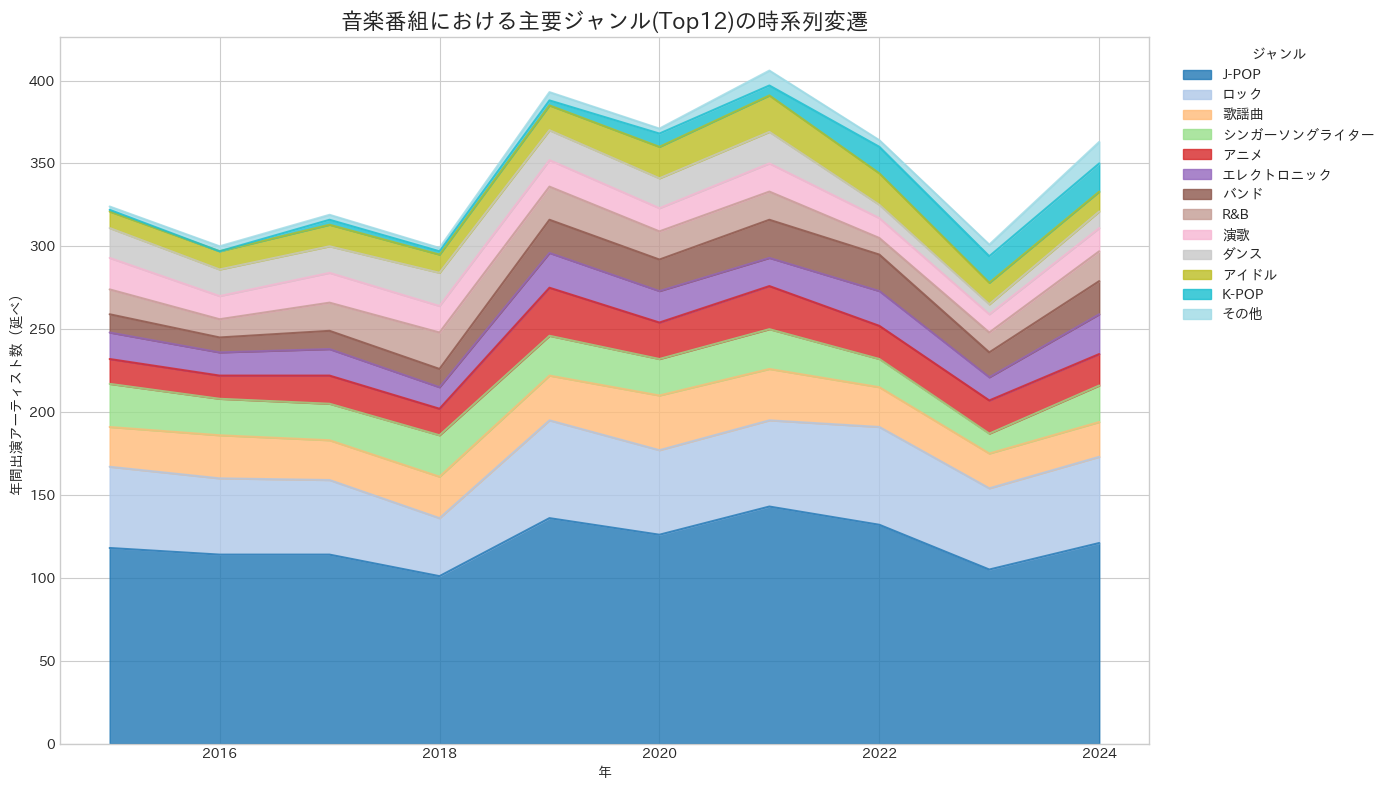


--- 2. 新興ジャンルの発見と未来予測 ---
「新興度スコア」に基づき、今最も勢いのあるTop 3ジャンルを予測します: K-POP, ヒップホップ, バンド


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


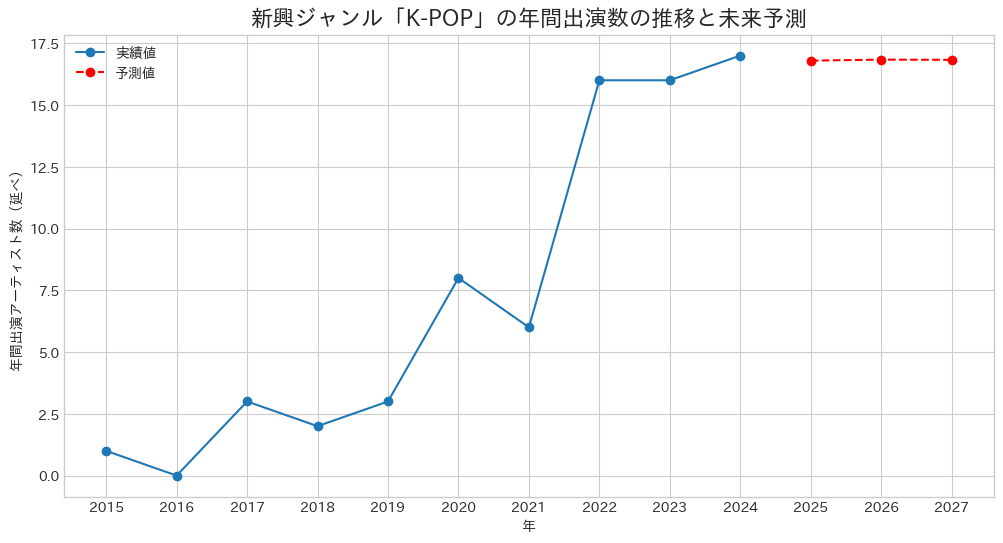


--- 「K-POP」の代表的なアーティスト ---
このジャンルでの出演回数トップ5:
1. NiziU (14回)
2. ジェジュン (9回)
3. TWICE (8回)
4. Stray Kids (6回)
5. LE SSERAFIM (6回)
----------------------------------------


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


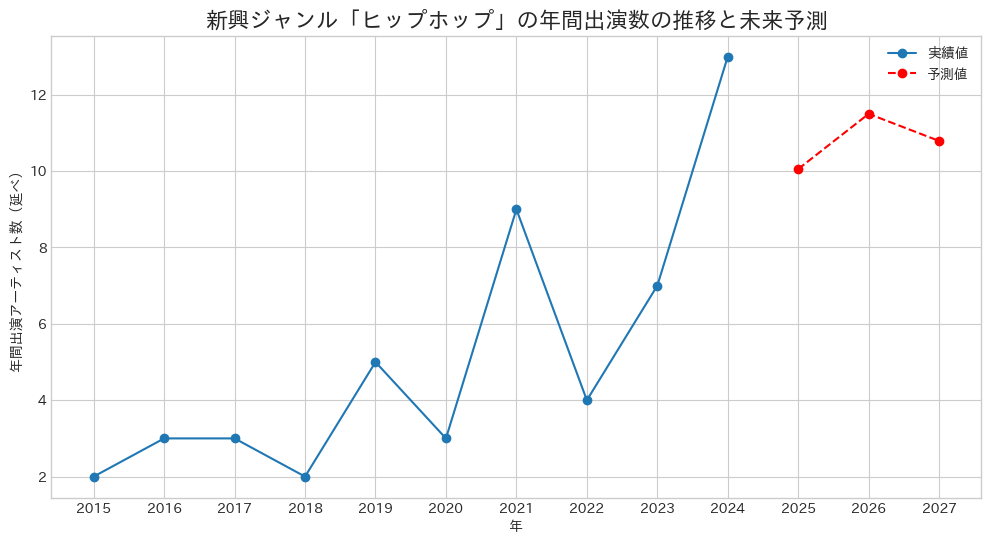


--- 「ヒップホップ」の代表的なアーティスト ---
このジャンルでの出演回数トップ5:
1. AI (12回)
2. THE RAMPAGE (6回)
3. Stray Kids (6回)
4. Creepy Nuts (4回)
5. ORANGE RANGE (2回)
----------------------------------------


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


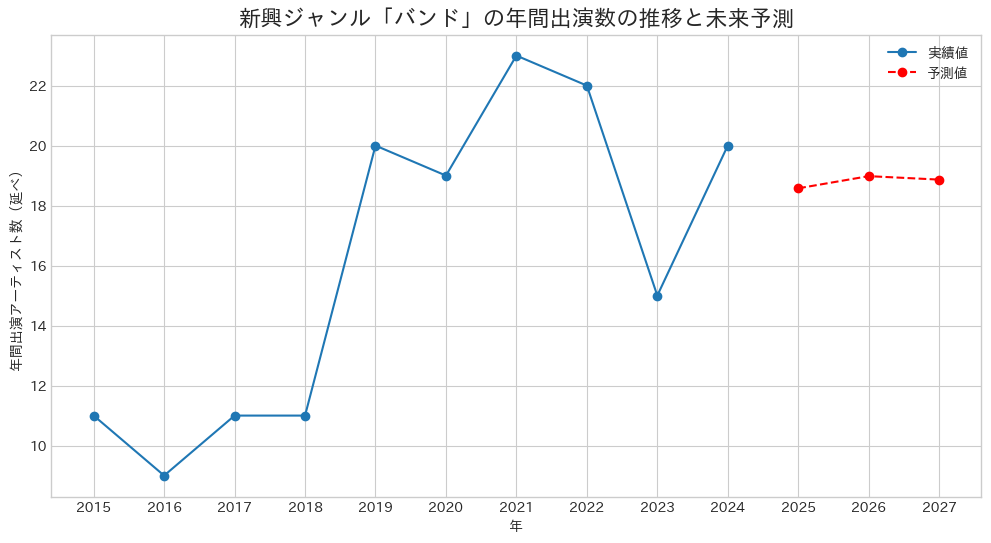


--- 「バンド」の代表的なアーティスト ---
このジャンルでの出演回数トップ5:
1. 嵐 (20回)
2. SixTONES (15回)
3. NEWS (14回)
4. KAT-TUN (13回)
5. Kis-My-Ft2 (13回)
----------------------------------------


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from statsmodels.tsa.arima.model import ARIMA

# --- Matplotlibのスタイルとフォントを明確に設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

# --- 設定 ---
# ユーザーがアップロードしたファイル名を使用
FILENAME = 'artist_master_final_v2.csv' 

# --- データ読み込みと前処理 ---
try:
    df = pd.read_csv(FILENAME)
except FileNotFoundError:
    print(f"[エラー] ファイル '{FILENAME}' が見つかりません。")
else:
    df['tags'] = df['tags'].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])

    # --- 1. ジャンルトレンドの変遷 ---
    print("--- 1. ジャンルトレンドの変遷を分析中 ---")
    df_exploded = df.explode('tags')
    genre_counts_by_year = df_exploded.groupby(['year', 'tags']).size().unstack(fill_value=0)
    
    top_n = 12
    top_genres = genre_counts_by_year.sum().nlargest(top_n).index.tolist()
    
    df_top_genres = genre_counts_by_year[top_genres].copy()
    df_top_genres.loc[:, 'その他'] = genre_counts_by_year.drop(columns=top_genres).sum(axis=1)

    fig, ax = plt.subplots(figsize=(14, 8))
    df_top_genres.plot(kind='area', stacked=True, ax=ax, alpha=0.8, colormap='tab20')
    
    ax.set_title(f'音楽番組における主要ジャンル(Top{top_n})の時系列変遷', fontsize=16)
    ax.set_ylabel('年間出演アーティスト数（延べ）')
    ax.set_xlabel('年')
    ax.legend(title='ジャンル', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 2. 新興ジャンルの発見と未来予測 ---
    print("\n--- 2. 新興ジャンルの発見と未来予測 ---")
    
    # === 修正箇所: 「新興度スコア」を計算してTop3を抽出 ===
    first_half_end = df['year'].min() + 4
    
    # 前半と後半の合計出演回数を計算
    first_half_counts = genre_counts_by_year[genre_counts_by_year.index <= first_half_end].sum()
    second_half_counts = genre_counts_by_year[genre_counts_by_year.index > first_half_end].sum()
    
    # 新興度スコアを計算（ゼロ除算を避けるため+1する）
    emergence_score = (second_half_counts + 1) / (first_half_counts + 1)
    
    # スコアが高い順に並べ替え、上位3ジャンルを選択
    top_emerging_genres = emergence_score.nlargest(3).index.tolist()
    
    if not top_emerging_genres:
        print("新興ジャンルを特定できませんでした。")
    else:
        print(f"「新興度スコア」に基づき、今最も勢いのあるTop 3ジャンルを予測します: {', '.join(top_emerging_genres)}")
        
        for genre in top_emerging_genres:
            series = genre_counts_by_year[genre]
            series.index = pd.to_datetime(series.index, format='%Y')

            try:
                model = ARIMA(series, order=(1, 1, 0))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=3)
            except Exception as e:
                print(f"ジャンル「{genre}」の予測モデル構築中にエラーが発生しました: {e}")
                continue

            fig, ax = plt.subplots(figsize=(12, 6))
            ax.plot(series.index.year, series.values, marker='o', label='実績値')
            ax.plot(forecast.index.year, forecast.values, marker='o', linestyle='--', color='red', label='予測値')
            
            ax.set_title(f'新興ジャンル「{genre}」の年間出演数の推移と未来予測', fontsize=16)
            ax.set_ylabel('年間出演アーティスト数（延べ）')
            ax.set_xlabel('年')
            ax.legend()
            plt.xticks(list(series.index.year) + list(forecast.index.year))
            plt.grid(True)
            plt.show()

            print(f"\n--- 「{genre}」の代表的なアーティスト ---")
            genre_specific_df = df_exploded[df_exploded['tags'] == genre]
            top_artists_series = genre_specific_df['artist'].value_counts()
            top_5_list = top_artists_series.head(5).index.tolist()
            
            print(f"このジャンルでの出演回数トップ5:")
            for i, artist_name in enumerate(top_5_list, 1):
                count = top_artists_series[artist_name]
                print(f"{i}. {artist_name} ({count}回)")
            print("-" * 40)

--- 1. 番組ごとのジャンル構成を比較中 ---


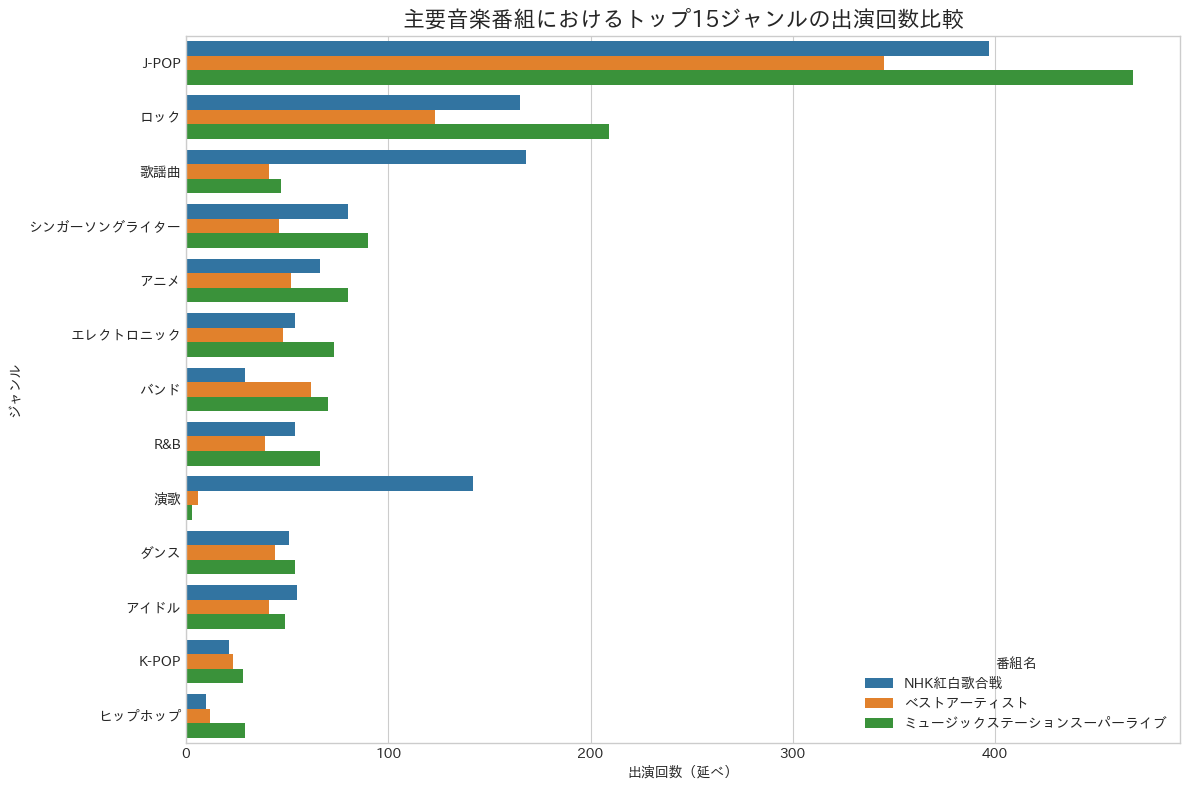


--- 2. 番組ごとのアーティスト形態を比較中 ---


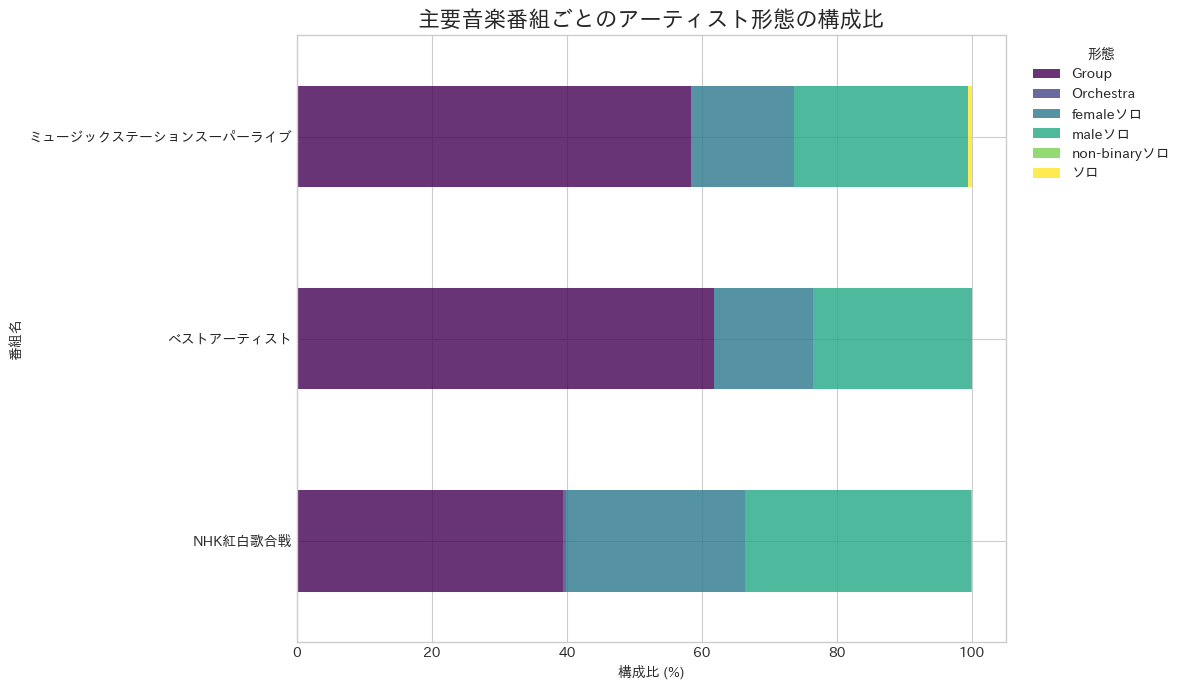

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MultiLabelBinarizer

# --- Matplotlibのスタイルとフォントを明確に設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

# --- 設定 ---
FILENAME = 'artist_master_final_v2.csv' 

# --- データ読み込みと前処理 ---
try:
    df = pd.read_csv(FILENAME)
except FileNotFoundError:
    print(f"[エラー] ファイル '{FILENAME}' が見つかりません。")
else:
    df['tags'] = df['tags'].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])
    
    # --- 1. 番組ごとのジャンル構成比較 ---
    print("--- 1. 番組ごとのジャンル構成を比較中 ---")
    
    df_exploded = df.explode('tags')
    top_15_genres = df_exploded['tags'].value_counts().nlargest(15).index

    plt.figure(figsize=(12, 8))
    sns.countplot(data=df_exploded[df_exploded['tags'].isin(top_15_genres)], y='tags', hue='program', order=top_15_genres)
    plt.title('主要音楽番組におけるトップ15ジャンルの出演回数比較', fontsize=16)
    plt.xlabel('出演回数（延べ）')
    plt.ylabel('ジャンル')
    plt.legend(title='番組名')
    plt.tight_layout()
    plt.show()

    # --- 2. 番組ごとのアーティスト形態比較 ---
    print("\n--- 2. 番組ごとのアーティスト形態を比較中 ---")
    
    type_ratios = pd.crosstab(df['program'], df['type'], normalize='index') * 100

    fig, ax = plt.subplots(figsize=(12, 7))
    type_ratios.plot(kind='barh', stacked=True, ax=ax, colormap='viridis', alpha=0.8)
    
    ax.set_title('主要音楽番組ごとのアーティスト形態の構成比', fontsize=16)
    ax.set_xlabel('構成比 (%)')
    ax.set_ylabel('番組名')
    ax.legend(title='形態', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

ファイル 'artist_master_final_v2.csv' を読み込みました。

--- 1. 統合特徴量ベクトルを作成中 ---
--- 統合ベクトルによる類似度計算が完了しました ---

--- 推薦システムの実行 & グラフ可視化 ---

▼ 「あいみょん」と総合的に傾向が似ているアーティスト Top 4:
  - 福山雅治 (類似度: 0.676)
  - MISIA (類似度: 0.615)
  - aiko (類似度: 0.599)
  - 櫻坂46 (類似度: 0.592)


/tmp/ipykernel_708/3002463302.py:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  grouped_tags = df.groupby('artist')['tags'].agg(sum)
/tmp/ipykernel_708/3002463302.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


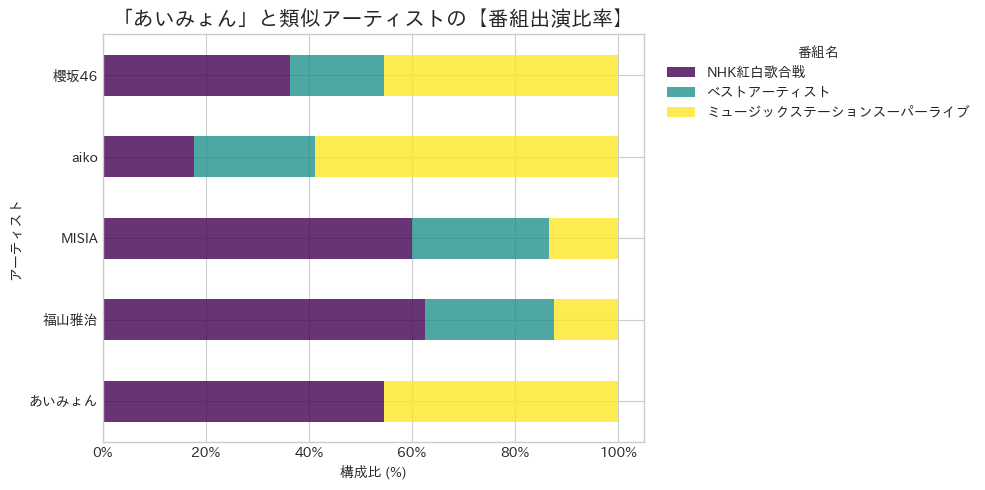

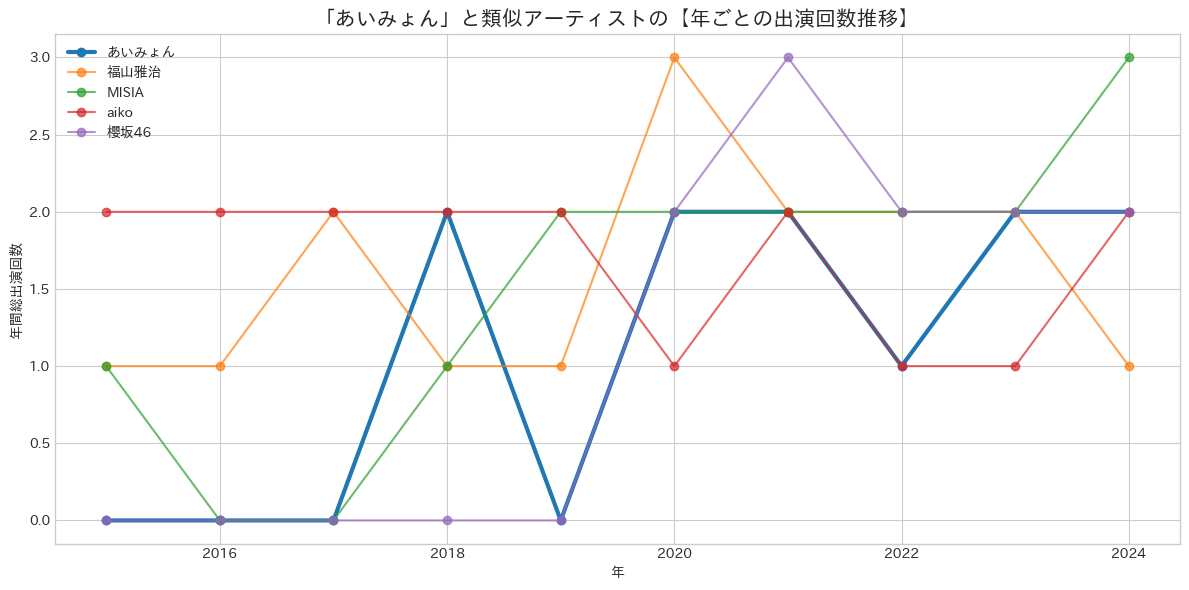

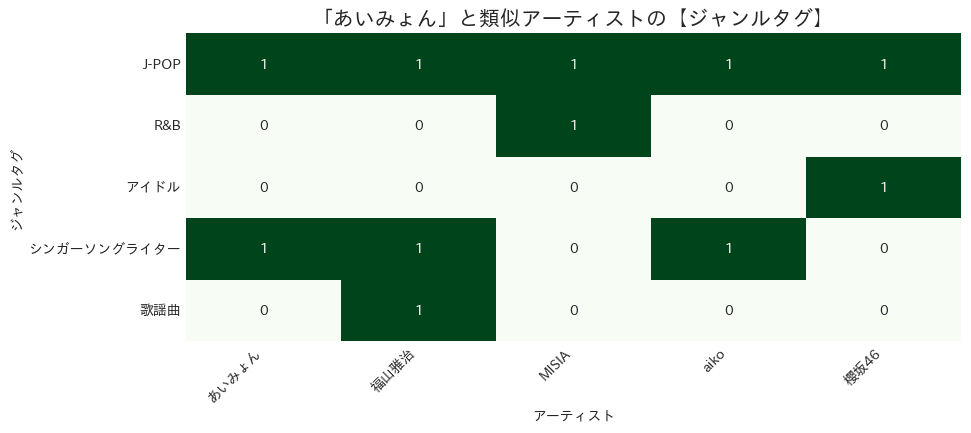


▼ 「King Gnu」と総合的に傾向が似ているアーティスト Top 4:
  - milet (類似度: 0.766)
  - Little Glee Monster (類似度: 0.634)
  - SEKAI NO OWARI (類似度: 0.598)
  - Official髭男dism (類似度: 0.588)


/tmp/ipykernel_708/3002463302.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])


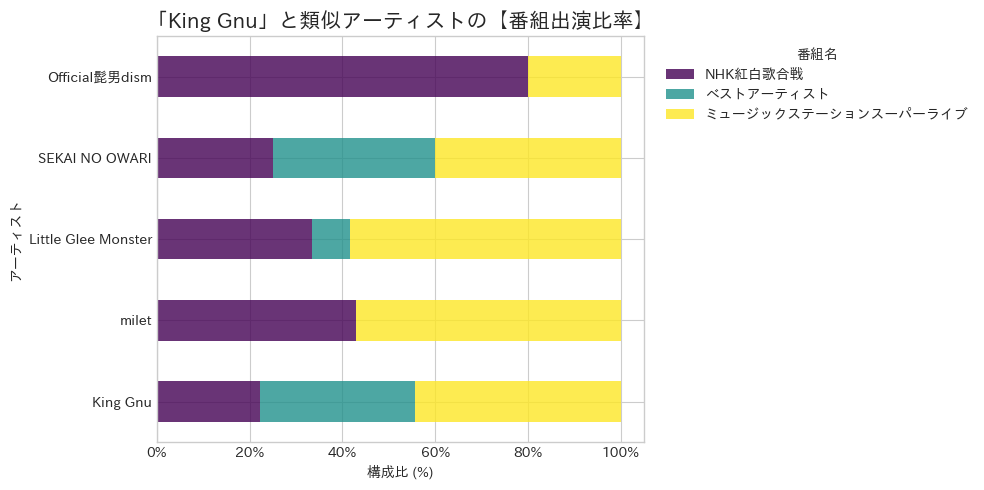

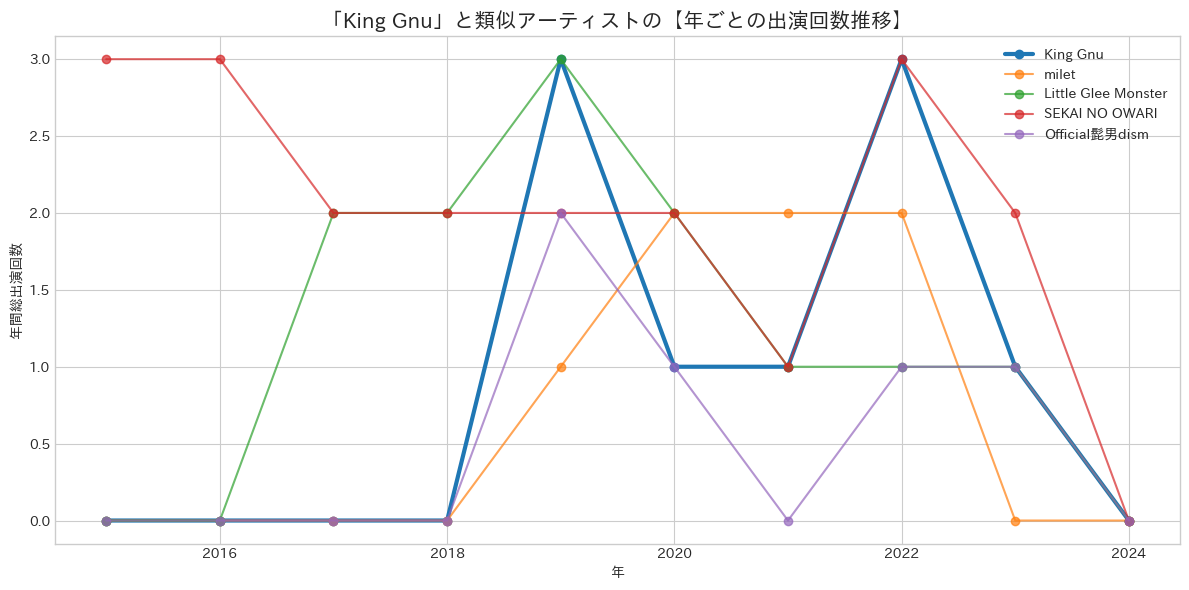

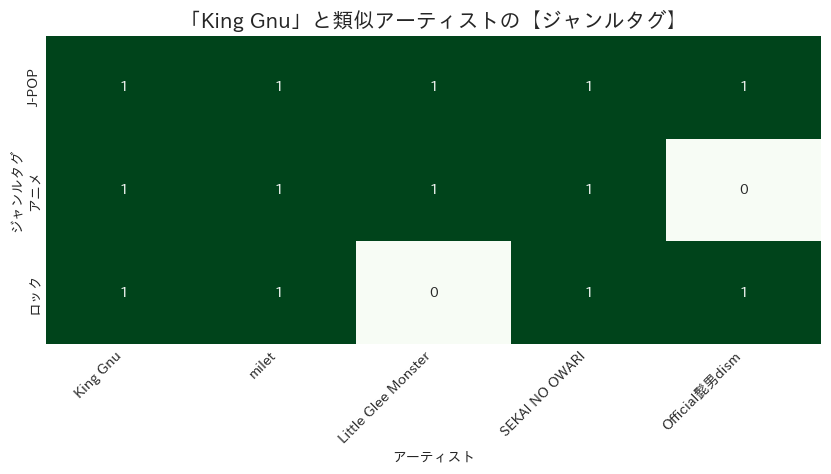

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# --- 設定 ---
FILENAME = 'artist_master_final_v2.csv'

# --- データ読み込み ---
try:
    df = pd.read_csv(FILENAME)
    print(f"ファイル '{FILENAME}' を読み込みました。")
except FileNotFoundError:
    print(f"[エラー] ファイル '{FILENAME}' が見つかりません。")
else:
    df['tags'] = df['tags'].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])

    # --- 1. 統合特徴量ベクトルの作成 ---
    print("\n--- 1. 統合特徴量ベクトルを作成中 ---")
    
    # 特徴量①：出演番組のマトリックス
    artist_program_matrix = pd.crosstab(df['artist'], df['program'])

    # 特徴量②：年ごとの出演回数ベクトル
    artist_year_matrix = pd.crosstab(df['artist'], df['year'])

    # 特徴量③：ジャンルタグのベクトル
    grouped_tags = df.groupby('artist')['tags'].agg(sum)
    mlb = MultiLabelBinarizer()
    artist_genre_matrix = pd.DataFrame(mlb.fit_transform(grouped_tags),
                                     columns=mlb.classes_,
                                     index=grouped_tags.index)

    # 3つの特徴量を結合
    combined_features = pd.concat([artist_program_matrix, artist_year_matrix, artist_genre_matrix], axis=1).fillna(0)
    
    # === 修正箇所: 全ての列名を文字列に変換 ===
    combined_features.columns = combined_features.columns.astype(str)
    
    # --- 2. フィーチャースケーリング ---
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(combined_features)

    # --- 3. コサイン類似度を計算 ---
    cosine_sim = cosine_similarity(scaled_features)
    similarity_df = pd.DataFrame(cosine_sim, index=combined_features.index, columns=combined_features.index)
    
    print("--- 統合ベクトルによる類似度計算が完了しました ---")

    # --- 4. 推薦と可視化の関数 ---
    def recommend_and_visualize(artist_name, top_n=5):
        if artist_name not in similarity_df.index:
            print(f"\nアーティスト「{artist_name}」はデータに含まれていません。")
            return

        similar_scores = similarity_df[artist_name].sort_values(ascending=False)
        recommendations = similar_scores.drop(artist_name).head(top_n)
        
        print(f"\n▼ 「{artist_name}」と総合的に傾向が似ているアーティスト Top {top_n}:")
        for rec_artist, score in recommendations.items():
            print(f"  - {rec_artist} (類似度: {score:.3f})")

        artist_list = [artist_name] + recommendations.index.tolist()
        
        # グラフ1: 番組出演比率の比較
        program_df = artist_program_matrix.loc[artist_list]
        program_ratio_df = program_df.div(program_df.sum(axis=1), axis=0)
        fig, ax = plt.subplots(figsize=(10, 5))
        program_ratio_df.plot(kind='barh', stacked=True, ax=ax, colormap='viridis', alpha=0.8)
        ax.set_title(f"「{artist_name}」と類似アーティストの【番組出演比率】", size=15)
        ax.set_xlabel('構成比 (%)'); ax.set_ylabel('アーティスト')
        ax.legend(title='番組名', bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
        plt.tight_layout(); plt.show()

        # グラフ2: 年ごとの出演回数推移の比較
        era_df = artist_year_matrix.loc[artist_list]
        fig, ax = plt.subplots(figsize=(12, 6))
        for artist in era_df.index:
            ax.plot(era_df.columns, era_df.loc[artist], marker='o', 
                    linewidth=(3 if artist == artist_name else 1.5), 
                    alpha=(1.0 if artist == artist_name else 0.7),
                    label=artist)
        ax.set_title(f"「{artist_name}」と類似アーティストの【年ごとの出演回数推移】", size=15)
        ax.set_xlabel('年'); ax.set_ylabel('年間総出演回数')
        ax.legend()
        plt.grid(True)
        plt.tight_layout(); plt.show()
        
        # グラフ3: ジャンルタグの比較
        genre_df = artist_genre_matrix.loc[artist_list].T
        genre_df = genre_df.loc[(genre_df != 0).any(axis=1)]
        if not genre_df.empty:
            fig, ax = plt.subplots(figsize=(10, max(4, 0.5 * len(genre_df))))
            sns.heatmap(genre_df, cmap="Greens", annot=True, cbar=False, ax=ax)
            ax.set_title(f"「{artist_name}」と類似アーティストの【ジャンルタグ】", size=15)
            ax.set_xlabel('アーティスト'); ax.set_ylabel('ジャンルタグ')
            plt.xticks(rotation=45, ha='right'); plt.show()

    # --- 5. 実際に推薦と可視化を実行 ---
    print("\n--- 推薦システムの実行 & グラフ可視化 ---")
    recommend_and_visualize('あいみょん', top_n=4)
    recommend_and_visualize('King Gnu', top_n=4)

ファイル 'artist_master_final_v2.csv' を読み込みました。
「J-POP」タグを持つ出演履歴は 1210 件ありました。


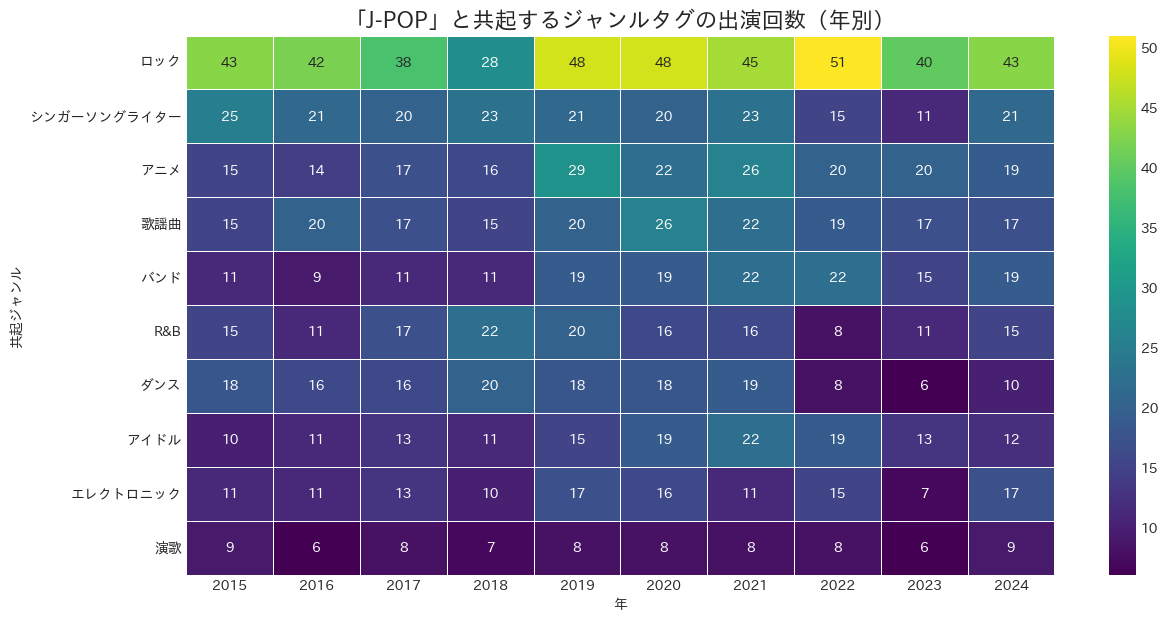

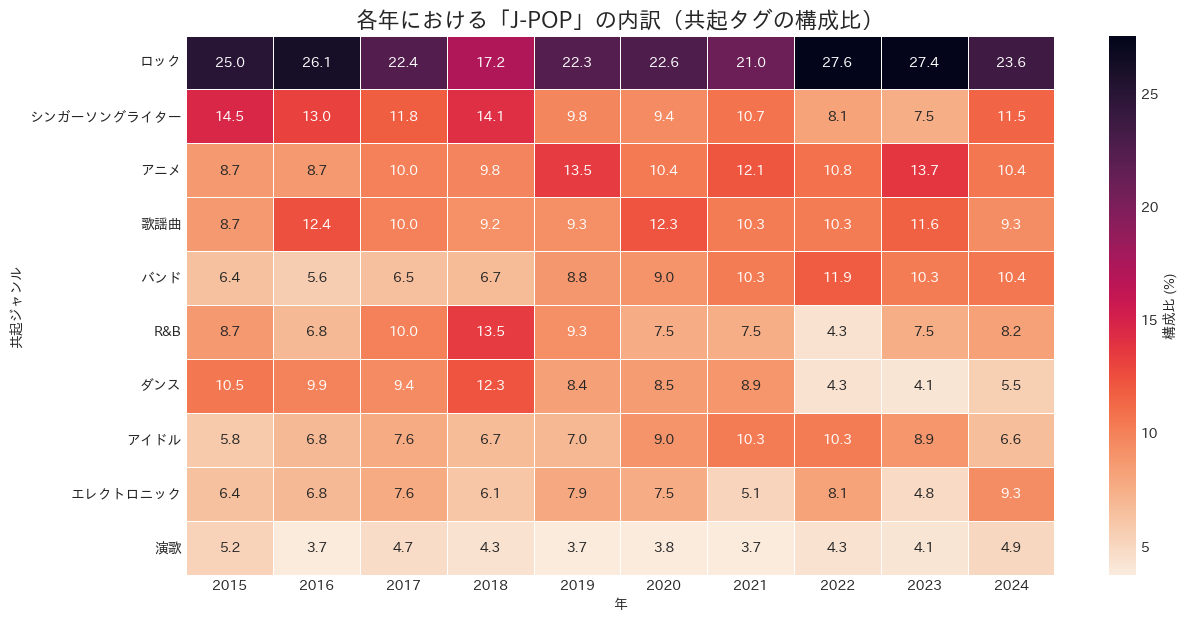

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# --- Matplotlibのスタイルとフォントを明確に設定 ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

# --- 設定 ---
FILENAME = 'artist_master_final_v2.csv'
TARGET_GENRE = 'J-POP'

# --- データ読み込みと前処理 ---
try:
    df = pd.read_csv(FILENAME)
    print(f"ファイル '{FILENAME}' を読み込みました。")
except FileNotFoundError:
    print(f"[エラー] ファイル '{FILENAME}' が見つかりません。")
else:
    df['tags'] = df['tags'].fillna('').apply(lambda x: [tag.strip() for tag in x.split(',') if tag.strip()])

    # --- 1. 「J-POP」タグを持つ出演履歴のみを抽出 ---
    jpop_df = df[df['tags'].apply(lambda tags: TARGET_GENRE in tags)].copy()
    print(f"「{TARGET_GENRE}」タグを持つ出演履歴は {len(jpop_df)} 件ありました。")

    # --- 2. J-POPとの共起（同時に出現する）タグを年ごとに集計 ---
    co_occurrence_list = []
    for index, row in jpop_df.iterrows():
        year = row['year']
        # J-POP以外のタグをリストアップ
        other_tags = [tag for tag in row['tags'] if tag != TARGET_GENRE]
        for tag in other_tags:
            co_occurrence_list.append({'year': year, 'co_genre': tag})
            
    co_occurrence_df = pd.DataFrame(co_occurrence_list)

    # 年ごと、共起ジャンルごとの出現回数を集計
    co_occurrence_counts = pd.crosstab(co_occurrence_df['co_genre'], co_occurrence_df['year'])
    
    # --- 3. 分析と可視化 ---
    if co_occurrence_counts.empty:
        print("共起するジャンルが見つかりませんでした。")
    else:
        # 共起回数が多い上位10ジャンルに絞る
        top_co_genres = co_occurrence_counts.sum(axis=1).nlargest(10).index
        heatmap_data = co_occurrence_counts.loc[top_co_genres]

        # --- グラフ1: 共起回数のヒートマップ ---
        plt.figure(figsize=(14, 7))
        sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='d', linewidths=.5)
        plt.title(f'「{TARGET_GENRE}」と共起するジャンルタグの出演回数（年別）', fontsize=16)
        plt.xlabel('年')
        plt.ylabel('共起ジャンル')
        plt.show()

        # --- グラフ2: 構成比率のヒートマップ（より重要）---
        # 年ごとに正規化（合計が100%になるように構成比を計算）
        normalized_heatmap_data = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100

        plt.figure(figsize=(14, 7))
        sns.heatmap(normalized_heatmap_data, cmap='rocket_r', annot=True, fmt='.1f', linewidths=.5, cbar_kws={'label': '構成比 (%)'})
        plt.title(f'各年における「{TARGET_GENRE}」の内訳（共起タグの構成比）', fontsize=16)
        plt.xlabel('年')
        plt.ylabel('共起ジャンル')
        plt.show()